In [1]:
import os
import wave
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import scipy.signal as signal
import numpy as np

In [17]:
current_dir = os.getcwd()
wav_samples_dir = os.path.join(current_dir, "VAD_sound")
wav_samples = os.listdir(wav_samples_dir)
wav_file = os.path.join(wav_samples_dir, wav_samples[0])

In [18]:
wav, sr = librosa.load(wav_file, sr=None)

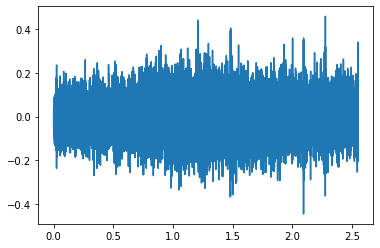

In [19]:
times = librosa.get_duration(filename=wav_file)
x = np.arange(0, times, 1.0/sr)
plt.plot(x, wav)
plt.show()

In [20]:
mfccs = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=24)

In [21]:
mfccs.shape # 返回值中第一个值为mfcc系数的长度大小，第二个参数为语音的帧数

(24, 240)

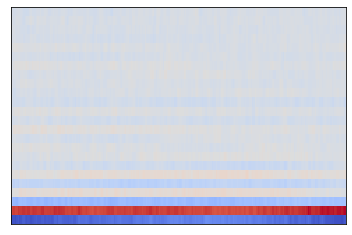

In [43]:
librosa.display.specshow(mfccs, sr=sr)
plt.show()

# 预处理

In [5]:
def pre_emphasis(wav_data, miu, mode="traditional"):
    signal_points = len(wav_data)
    signal_points = int(signal_points)
    if mode == "traditional":
        for i in range(1, signal_points, 1):
            wav_data[i] = wav_data[i] - miu * wav_data[i-1]
    elif mode == "updated":
        for i in range(1, signal_points, 1):
            wav_data[i] = wav_data[i] + miu * wav_data[i-1]
    else:
        print("no such mode")
    return wav_data

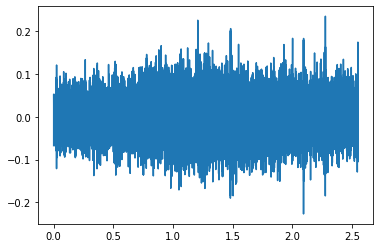

In [6]:
mode = "traditional" # traditional or updated
miu = 0.97
pre_empha_wav = pre_emphasis(wav_data=wav, miu=miu, mode=mode)
plt.plot(x, pre_empha_wav)
plt.show()

In [8]:
frame_size = 4096
hop_size = 512
winfunc = signal.windows.hamming(frame_size)
frames = librosa.util.frame(pre_empha_wav, frame_length=frame_size, hop_length=hop_size, axis=0)
frames = np.array([frame * winfunc for frame in frames])

# 短时能量

In [9]:
def calEnergy(frame):
    sumEnergy = 0
    for i in frame:
        sumEnergy += i**2
    return sumEnergy

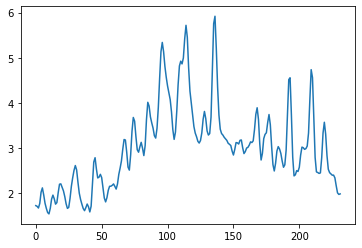

In [10]:
energy = []
for frame in frames:
    energy.append(calEnergy(frame))
energy = np.array(energy)
plt.plot(energy)
plt.show()

# 短时过零率

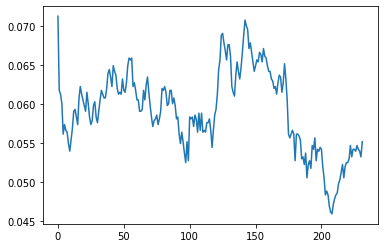

In [11]:
zeroCrossingRate = librosa.feature.zero_crossing_rate(pre_empha_wav, frame_length=frame_size, hop_length=hop_size, center=False)[0]
plt.plot(zeroCrossingRate)
plt.show()

# Root Mean Square Energy (RMSE)

In [12]:
rmse = librosa.feature.rms(pre_empha_wav, frame_length=frame_size, hop_length=hop_size, center=False)[0]

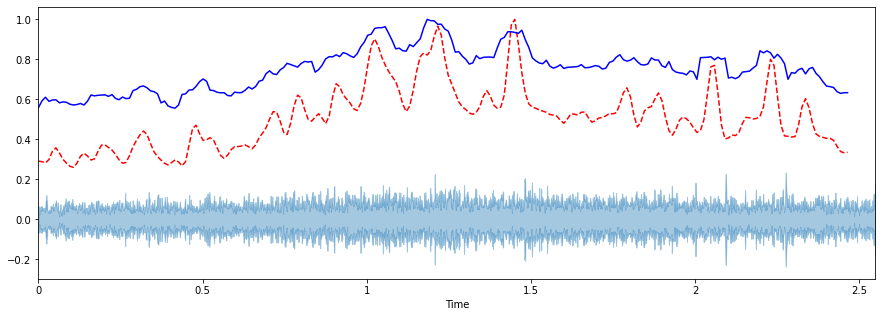

In [13]:
frames_length = range(len(energy))
t = librosa.frames_to_time(frames_length, sr=sr, hop_length=hop_size)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(pre_empha_wav, sr=sr, alpha=0.4)
plt.plot(t, energy/energy.max(), 'r--')
plt.plot(t[:len(rmse)], rmse/rmse.max(), color="blue")
plt.show()

# 短时傅里叶变换stft

In [14]:
D = librosa.stft(pre_empha_wav, n_fft=4096, hop_length=3584, win_length=4096, window="hamming")

In [15]:
magnitude = np.abs(D.T)

In [16]:
spectra = magnitude[0][:1200]

In [17]:
x = []
for i in range(len(spectra)):
    x.append(0 + i*48000/4096)
x = np.array(x)

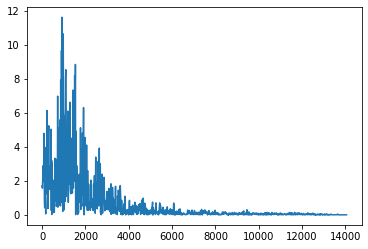

In [18]:
plt.plot(x, spectra)
plt.show()

In [19]:
spectra = spectra / np.sum(spectra)

In [20]:
C1 = 10000
C2 = 100
spectra = C2 * np.log10(C1*spectra + 1.0)

# 测试

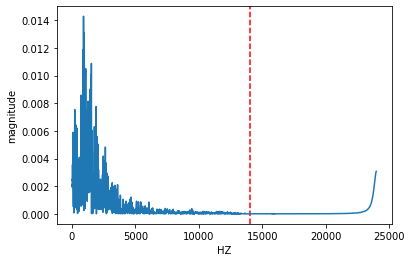

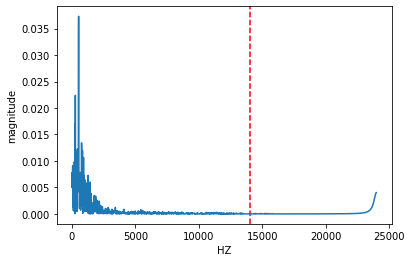

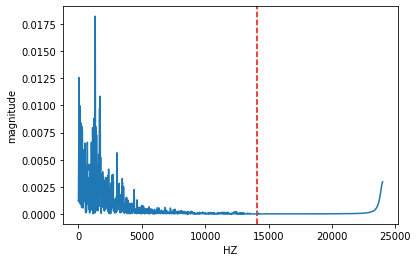

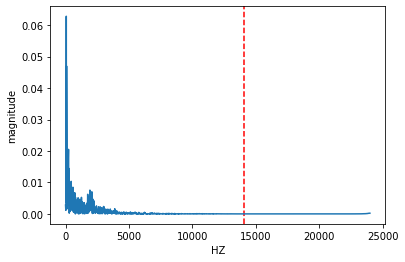

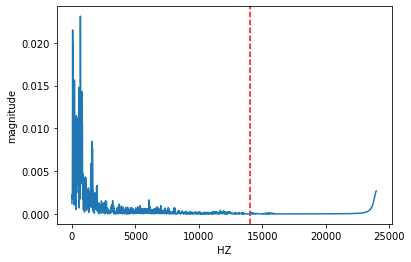

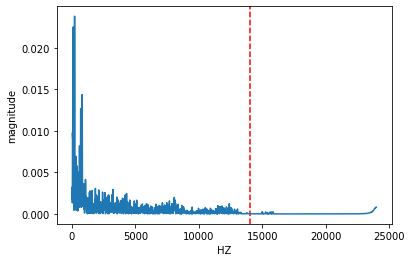

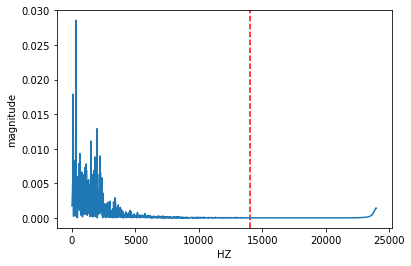

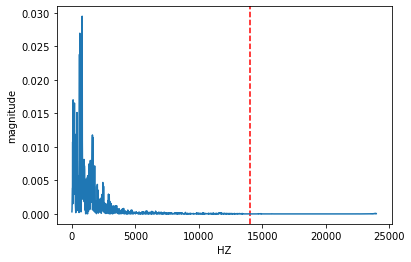

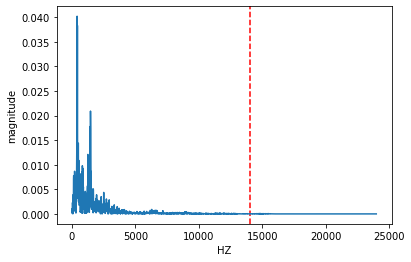

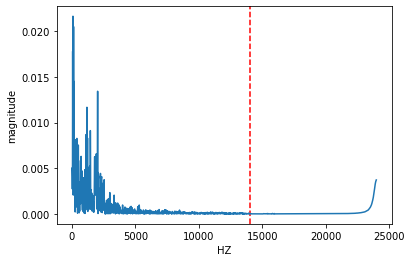

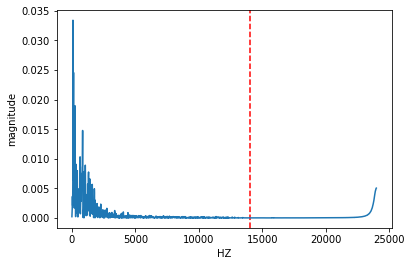

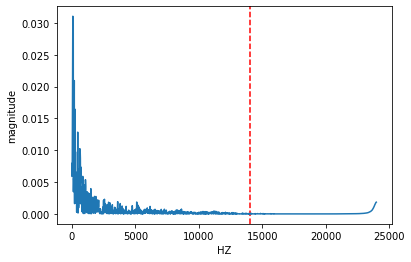

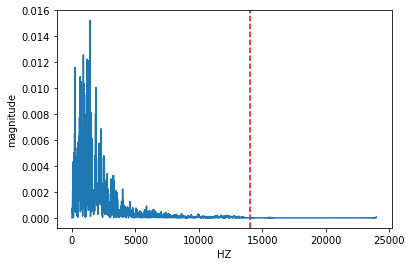

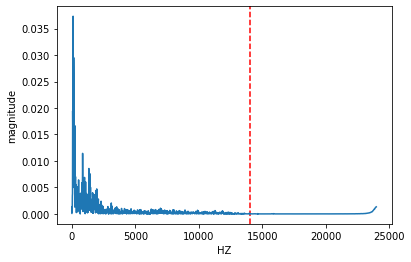

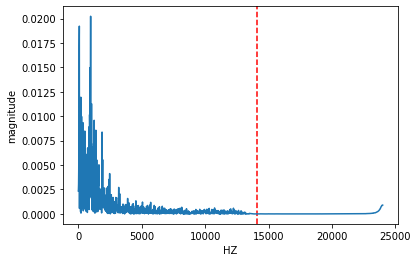

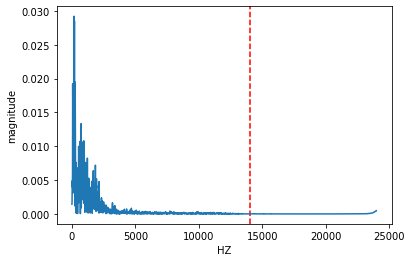

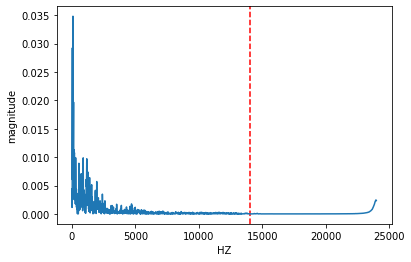

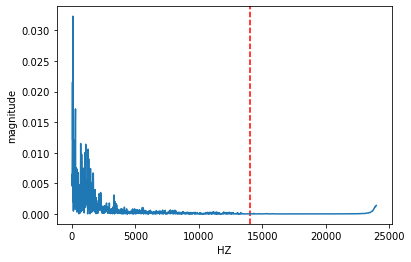

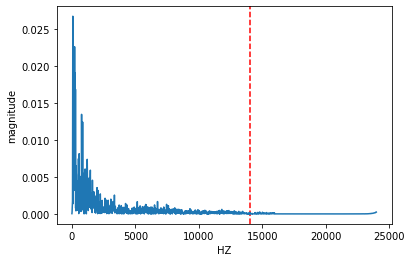

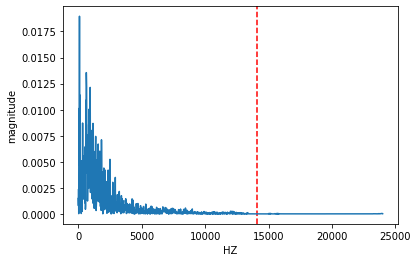

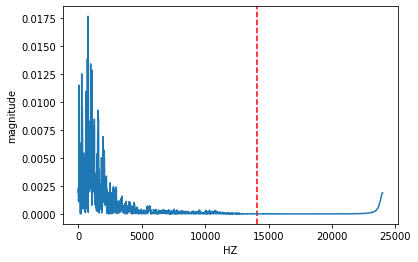

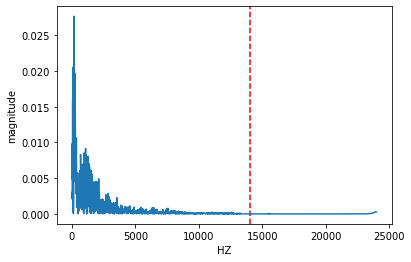

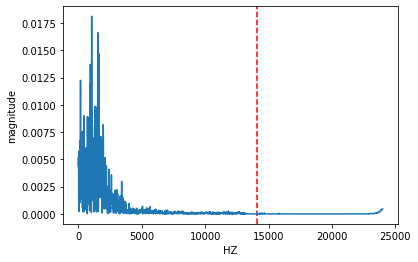

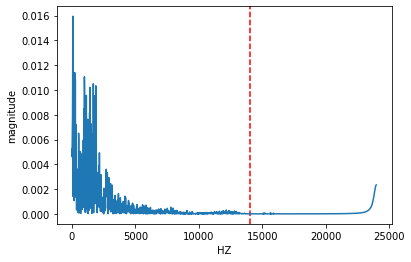

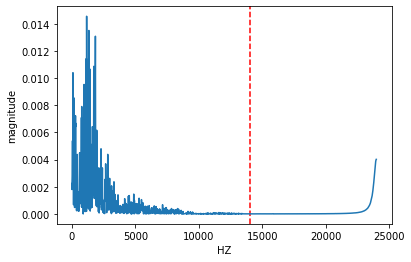

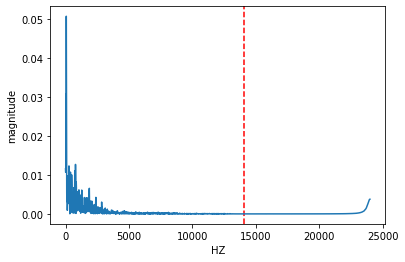

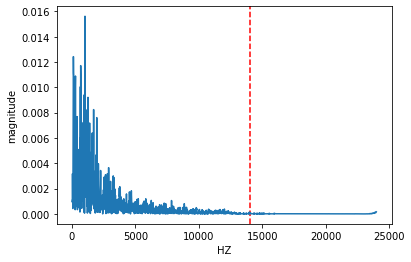

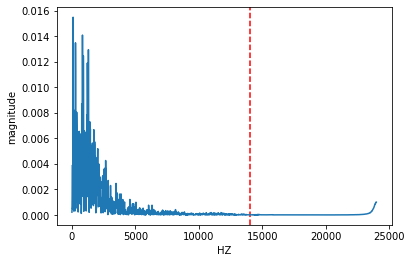

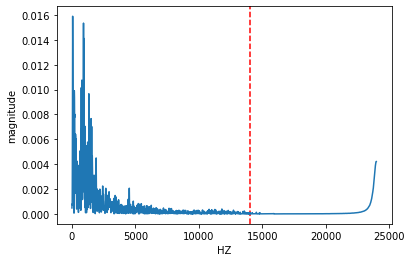

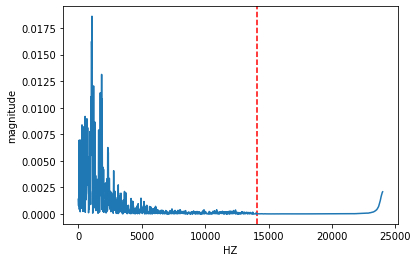

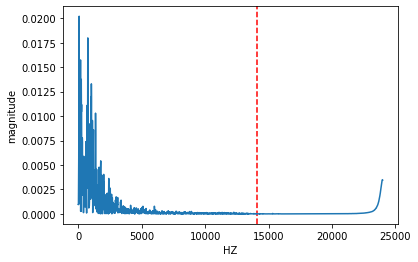

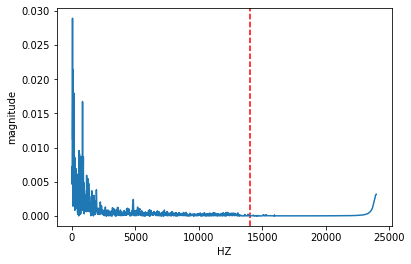

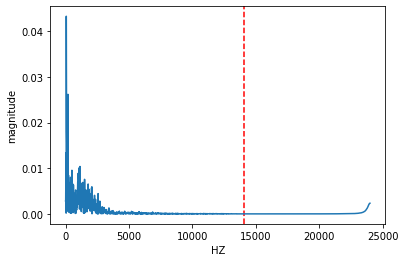

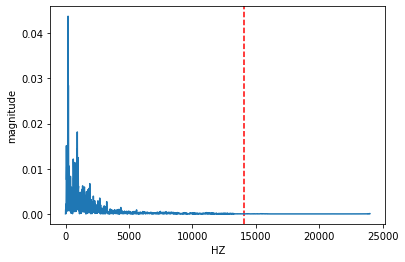

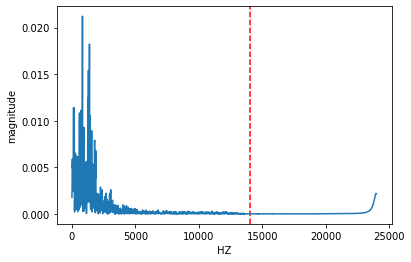

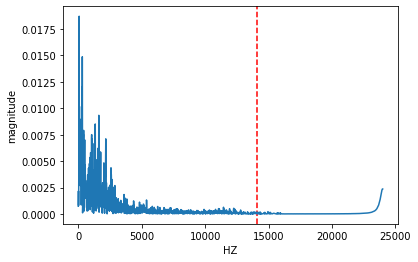

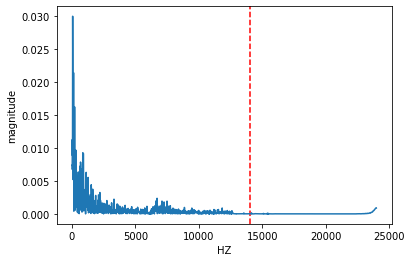

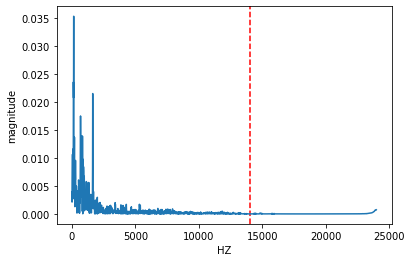

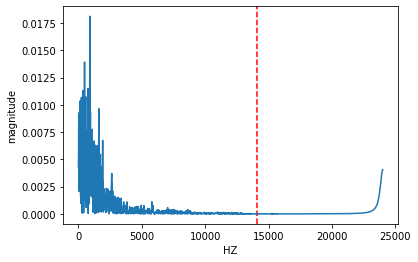

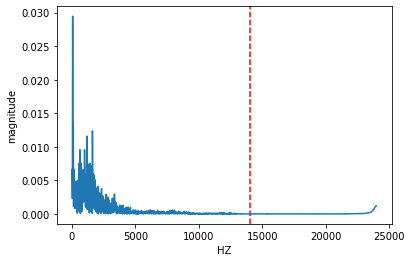

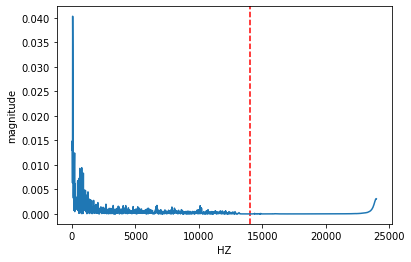

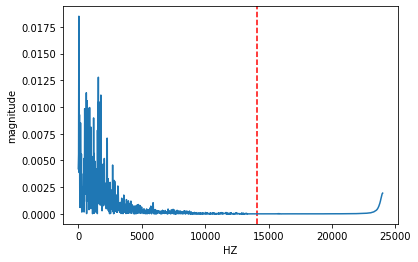

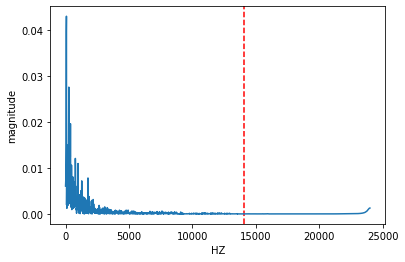

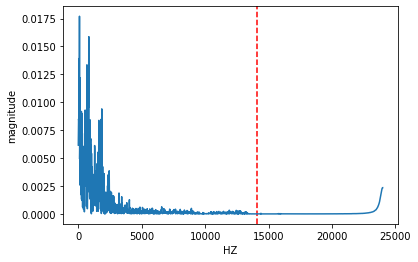

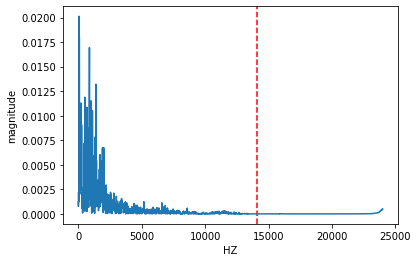

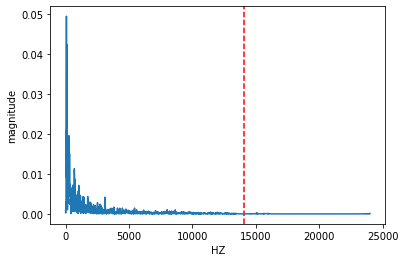

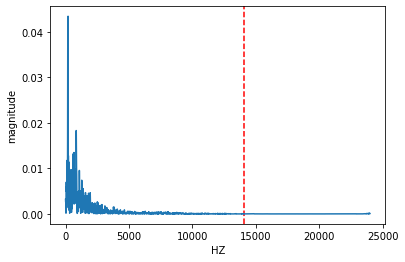

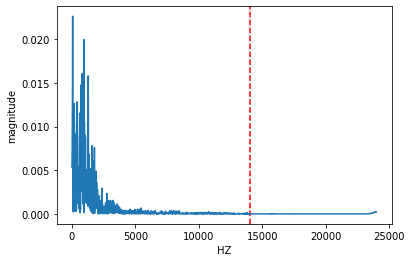

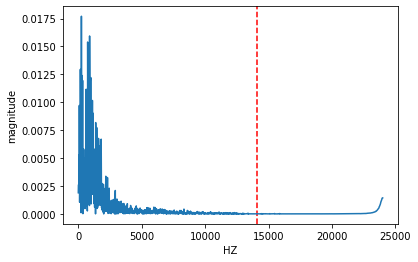

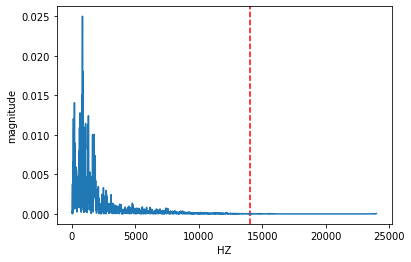

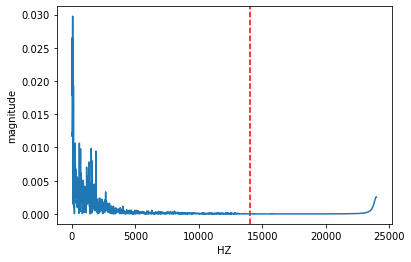

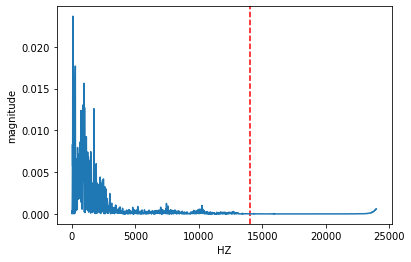

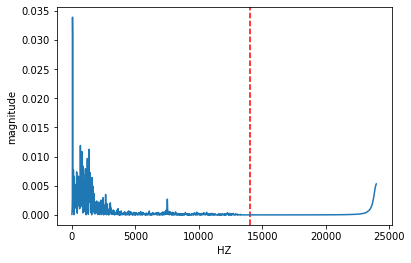

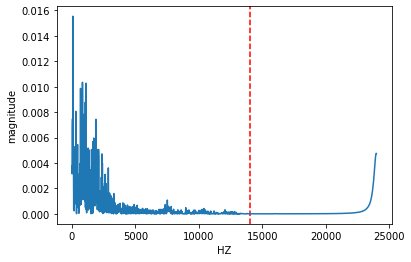

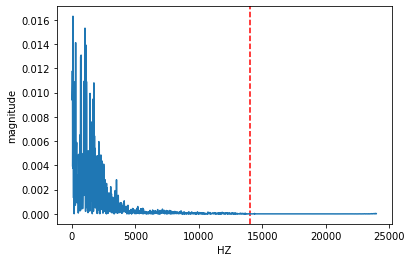

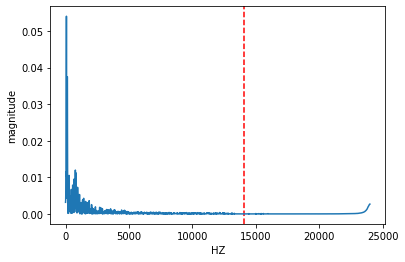

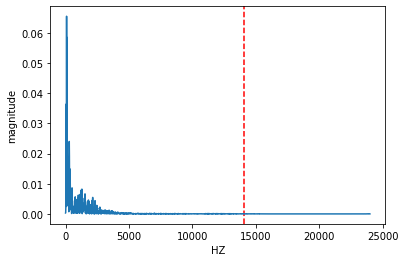

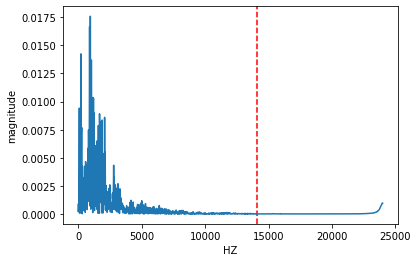

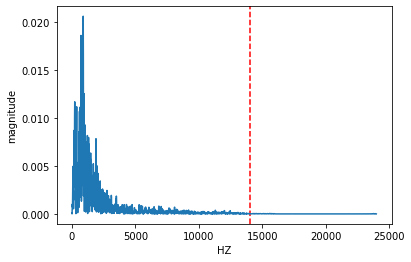

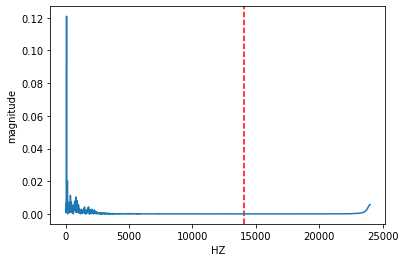

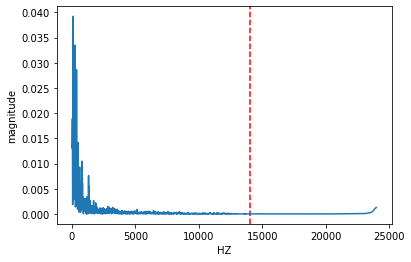

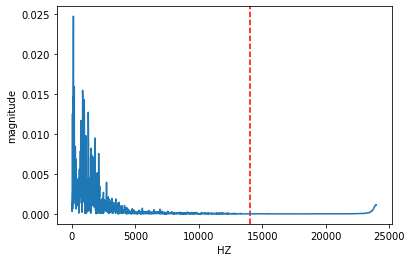

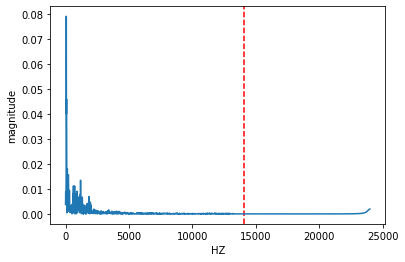

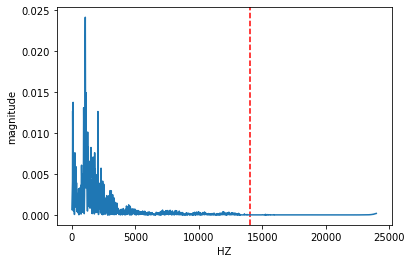

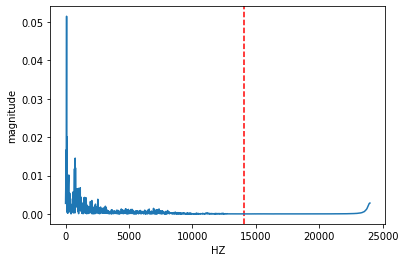

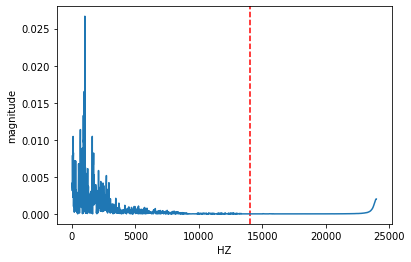

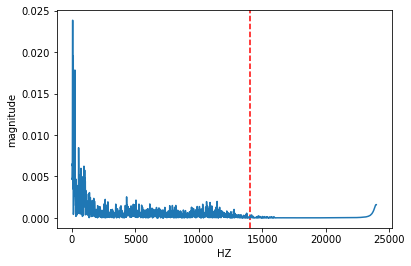

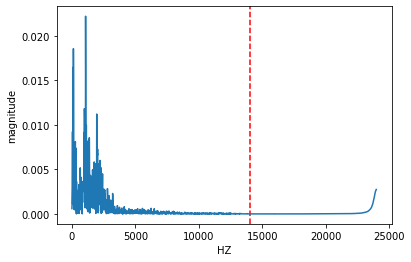

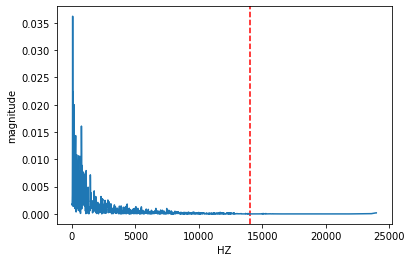

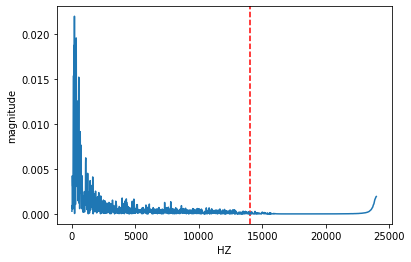

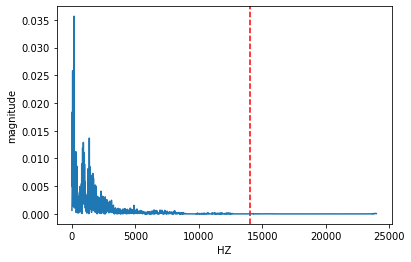

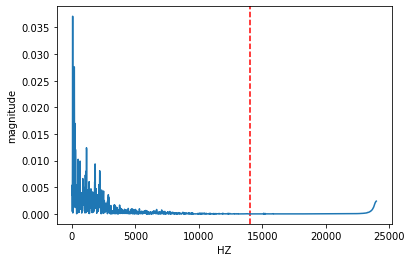

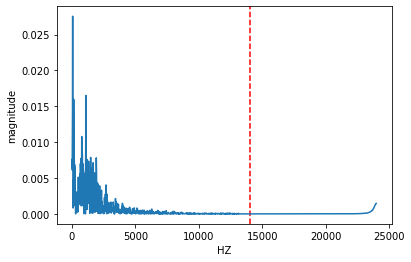

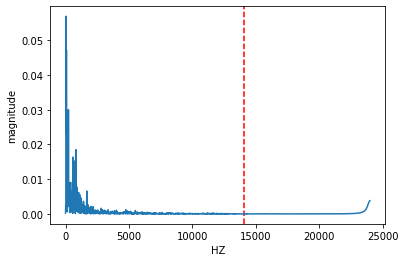

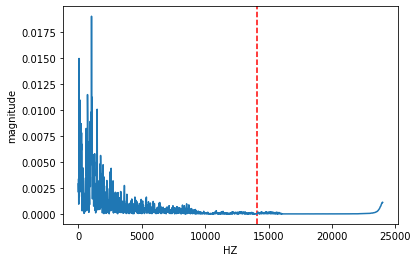

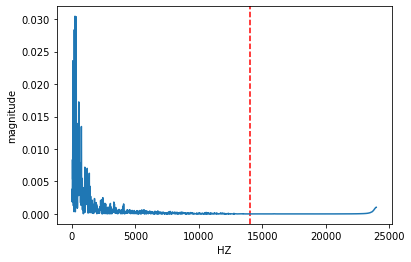

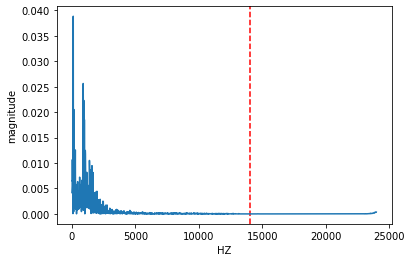

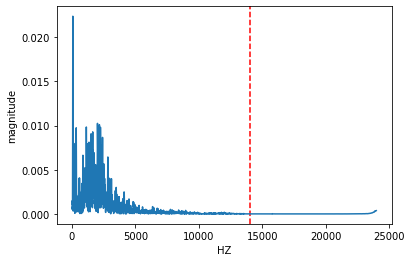

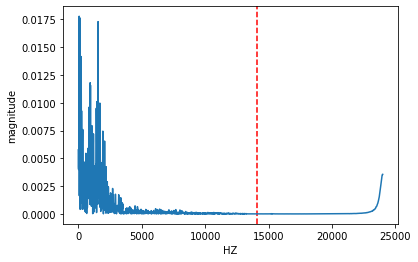

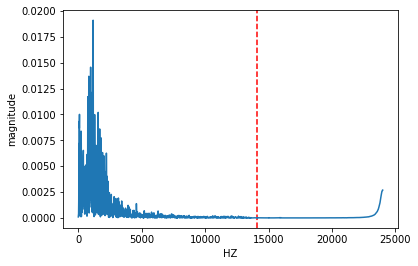

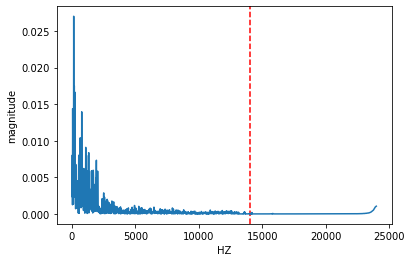

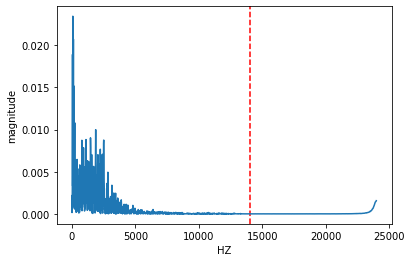

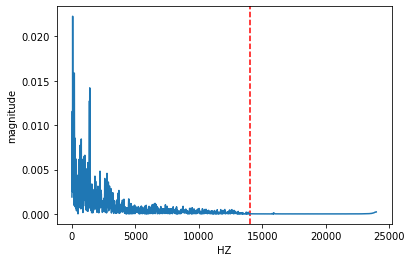

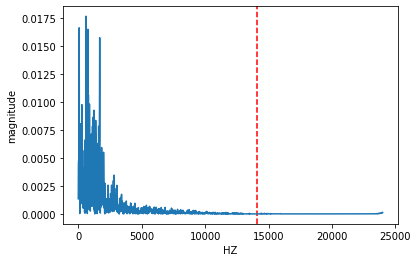

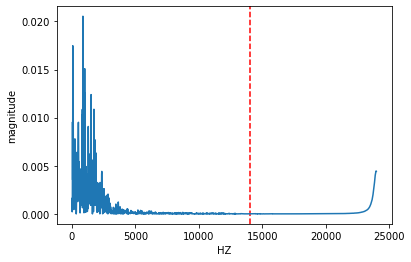

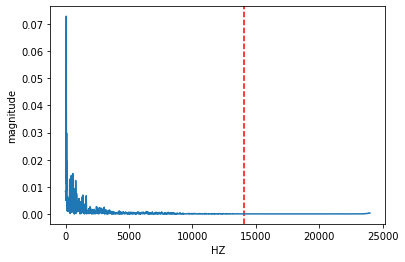

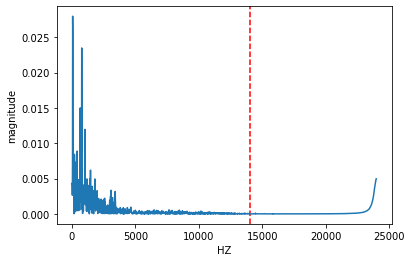

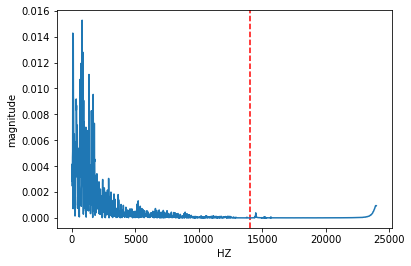

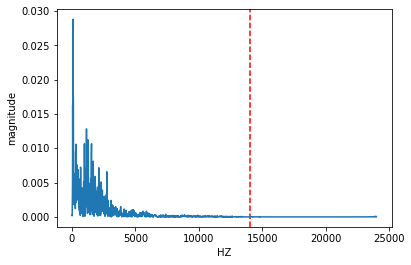

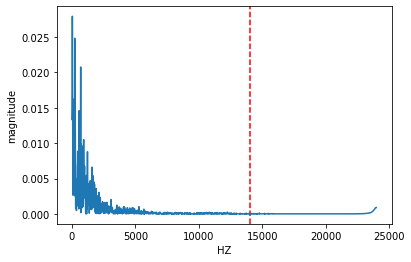

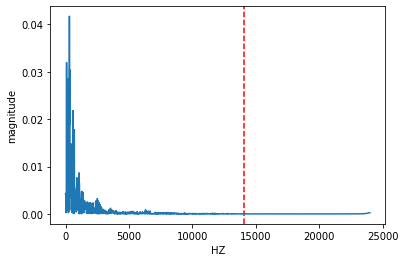

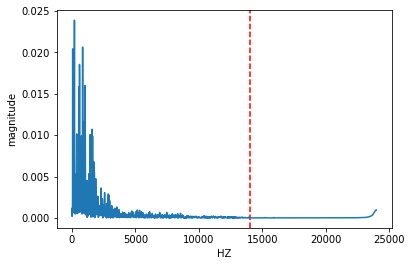

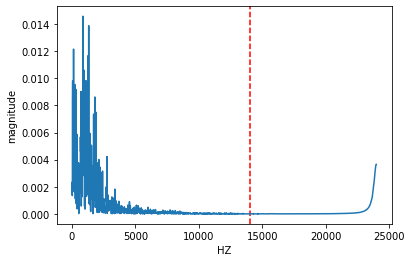

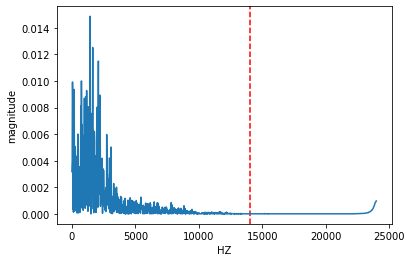

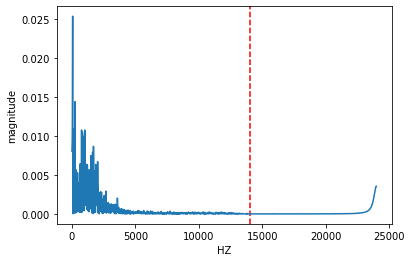

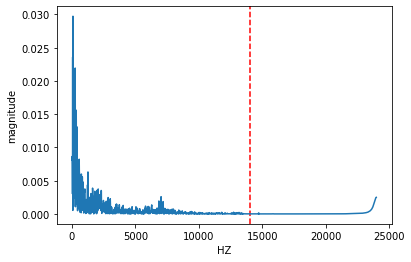

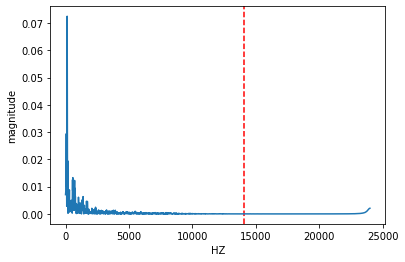

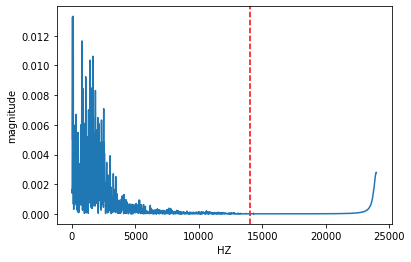

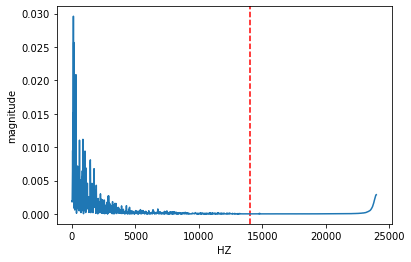

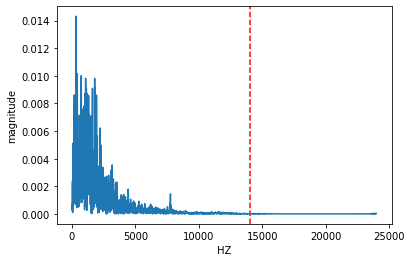

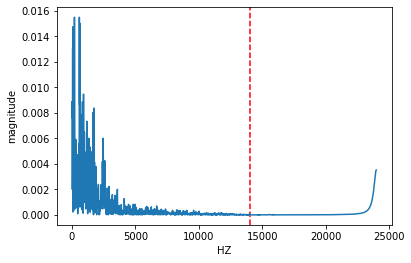

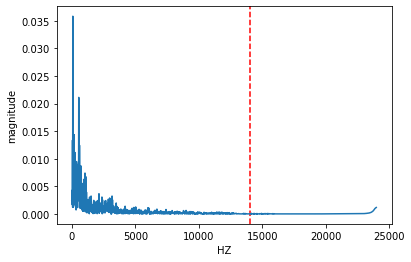

In [24]:
current_dir = os.getcwd()
wav_samples_dir = os.path.join(current_dir, "VAD_sound")
wav_samples = os.listdir(wav_samples_dir)
for i, wav_sample in enumerate(wav_samples):
    plt.figure(i)
    wav_file = os.path.join(wav_samples_dir, wav_sample)
    wav, sr = librosa.load(wav_file, sr=None)
    mode = "traditional" # traditional or updated
    miu = 0.97
    pre_empha_wav = pre_emphasis(wav_data=wav, miu=miu, mode=mode)
    D = librosa.stft(pre_empha_wav, n_fft=4096, hop_length=3584, win_length=4096, window="hamming")
    magnitude = np.abs(D.T)
    spectra = magnitude[0]
    spectra = spectra / np.sum(spectra)
    x = np.arange(0, 48000, 48000/4096)
    x = x[:len(spectra)]
    point = 1200
    plt.axvline(point*48000/4096, color="red", linestyle="--")
    plt.plot(x, spectra)
    plt.xlabel("HZ")
    plt.ylabel("magnitude")
    plt.show()

In [99]:
current_dir = os.getcwd()
wav_samples_dir = os.path.join(current_dir, "VAD_sound")
wav_samples = os.listdir(wav_samples_dir)
wav_file = os.path.join(wav_samples_dir, wav_samples[0])

## 绘制mel频谱图

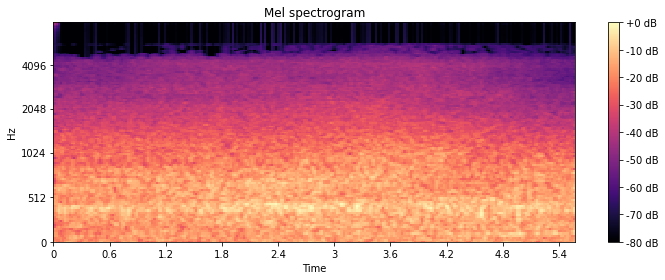

In [38]:
D = librosa.stft(pre_empha_wav, n_fft=2048, hop_length=512, win_length=2048, window="hamming")
D = np.abs(D) ** 2 # stft频谱
S = librosa.feature.melspectrogram(S=D)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

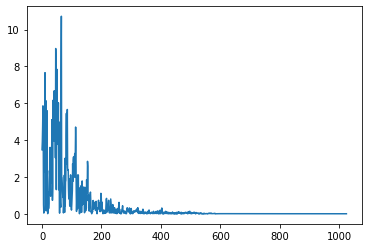

In [60]:
wav, sr = librosa.load(wav_file, sr=None)
wav, _ = librosa.effects.trim(wav)
n_fft = 2048
D = np.abs(librosa.stft(wav[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(D);

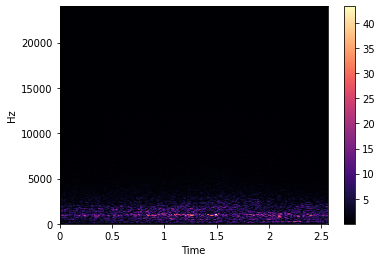

In [61]:
hop_length = 512
D = np.abs(librosa.stft(wav, n_fft=n_fft,  hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

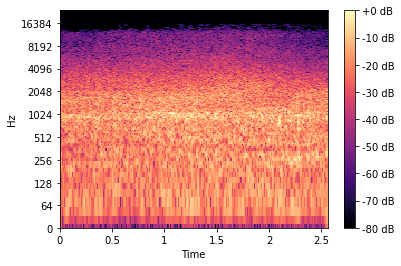

In [62]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

In [63]:
n_mels = 128
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

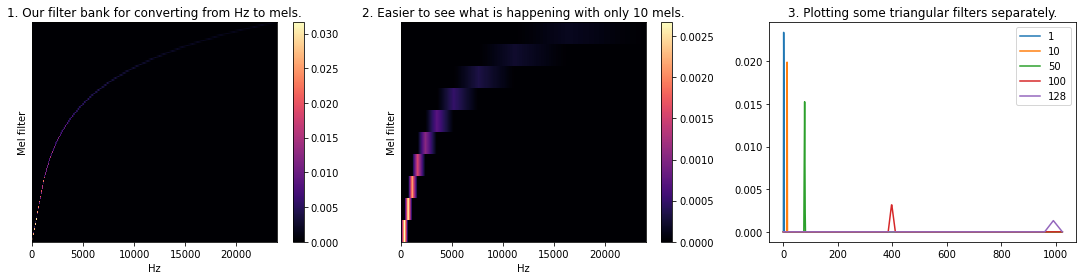

In [64]:

plt.figure(figsize=(15, 4));

plt.subplot(1, 3, 1);
librosa.display.specshow(mel, sr=sr, hop_length=hop_length, x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('1. Our filter bank for converting from Hz to mels.');

plt.subplot(1, 3, 2);
mel_10 = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=10)
librosa.display.specshow(mel_10, sr=sr, hop_length=hop_length, x_axis='linear');
plt.ylabel('Mel filter');
plt.colorbar();
plt.title('2. Easier to see what is happening with only 10 mels.');

plt.subplot(1, 3, 3);
idxs_to_plot = [0, 9, 49, 99, 127]
for i in idxs_to_plot:
    plt.plot(mel[i]);
plt.legend(labels=[f'{i+1}' for i in idxs_to_plot]);
plt.title('3. Plotting some triangular filters separately.');

plt.tight_layout();

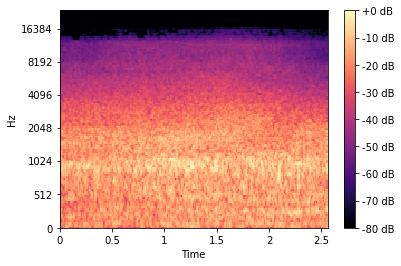

In [65]:
S = librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');